# Model Bias and Variance, a Tangible Approach


Two fundamental concepts in machine learning are that of **bias** and **variance**. While these concepts are widely-known, it's uncommon we are given anything more than an abstract formulaic representation of what bias and variance are, leading to much confusion. I will attempt to remedy this issue with this article.

## Basics

First, though, we must cover basics and set the stage. When we try to create predictive models, we are almost always trying to imitate some *unknown* relationship between *observations* $x$ and *parameters* (values we want to predict given the observations) $y$ by a "perfect equation" $y = f(x)$ as closely as possible. To take a simple example, let's say I want to predict the weight of an elephant $(y)$ given its height $(x)$. In a perfect world, we'd know what this equation is exactly. But it's not a perfect world.

Note that while the weight of an elephant is a constant (in the context of prediction, not in real life), the observations of height are certainly not. For example, let's say an elephant weighs $y = 10,000$ lb. Obviously, given this information the elephant's exact height isn't one-to-one. Instead, our heights follows a *distribution* $P(x | y)$- given an elephant weighs 10K pounds, it is much more likely to be around 8-10 ft tall as opposed to 2 feet tall. Unfortunately, this distribution is unknown.

So instead we we train an model $\hat{f}$. The best model will, given observed data $x$, produce an *estimate* $\hat{f}(x)$ that is as close to the true value $y = f(x)$ as possible. Remember that this true value $y$ is unknown, as is the relationship $f$.

## Model Bias

Now that we have our model,  we can say that the bias of $\hat{f}$ is the difference between the *average prediction* of $\hat{f}$ and the truth $y$. This difference, or *error*, is caused by assumptions in the learning mechanism itself- for example, if we use a linear regressor to predict data that follows a quadratic relationship, that will introduce a good amount of bias error. 

We say "average prediction" in the context of a single given input $x$, which simplifies our math a lot. Specifically, we want to calculate the below value, for a given input $x$ and *unknown* truth $f(x)$:

$$
E[\hat{f}(x)] - f(x)
$$

This will give us an indication of how "correct" our model is in matching the true relationship $f(x)$. Happily, there exists a way to estimate this bias.

Remember, "average prediction" is just in the context of *one* input-output pair $(x_0, y_0)$. Now, we're just looking at the average prediction of a single input observation- $\hat{f}(x_0)$. So now we can *simulate* the average prediction instead, by, well, averaging a bunch of predictions:

1. Sampling a bunch of training sets $D_1, D_2,...,D_N$

2. Training a model for each: $\hat{f}_1, \hat{f}_2,...,\hat{f}_N$

3. Averaging model predictions on $x_0$: $\frac{\sum_i \hat{f}_i(x_0)}{N}$. This gives us our average prediction $E[\hat{f}(x_0)]$.

Then we can finally get a numerical estimate of our bias $E[\hat{f}(x_0)] - y_0$. If we want, we can calculate this for all input-output pairs and average that to get an overall bias.

## Model Variance

The variance of our model $\hat{f}$ is independent of the truth label $y_0$ and more dependent on the intricacies and complexity of the model $\hat{f}$ itself. We know that variance of $\hat{f}$ is expected value of the **squared sampling deviations** of $\hat{f}$, where a sampling deviation is just the difference between a prediction and the average prediction (expected value):

$$
\hat{f}(x) - E[\hat{f}(x)]
$$

So variance is just equal to taking all these sampling deviations and averaging them.

Again in the context of a single input-output pair $(x_0, y_0)$, calculating the variance of $\hat{f}$ (at least on $x_0$) is very similar to bias: 

1. Sampling a bunch of training sets $D_1, D_2,...,D_N$

2. Training a model for each: $\hat{f}_1, \hat{f}_2,...,\hat{f}_N$

3. Calculate average prediction $E[\hat{f}(x_0)]$ by averaging model predictions on $x_0$

4. Calculate sampling deviations $\hat{f}_i(x) - E[\hat{f}(x)]$ for each trained model $i$.

5. Square these deviations, then average them to get our variance.

Again, we can average these single-training-pair variance calculations over all inputs and outputs to get a general idea of our variance!

Let's now actually apply this in code. Let's say we're trying to model truth 

$$
y = x^3
$$

and we collect some (noisy) data:

In [36]:
def f(x):
    return x ** 3

Remember that we although the true relationship is encoded by $f$, this will almost never be exact. There's always noise. So while in a perfect world we would have $y = f(x)$, we really have

$$
y = f(x) + \epsilon
$$

where $\epsilon$ is the noise that can come from measurement error, randomness in nature, or any other source that distorts the true value.

Let's now say our inputs are all uniform over $[0,1]$.  

In [234]:
def generate_sample_data(f, num_rows=100, lower=0, upper=1, noise_sd=0.25):
    """Generate a training set with NUM_ROWS rows containing 
    input values between [LOWER, UPPER], mapped to outputs given by f(x) + noise."""
    x = np.random.uniform(lower, upper, num_rows)
    noise = np.random.normal(loc=0, scale=noise_sd, size=num_rows)
    return np.vstack((x, f(x)+noise)).T

In [235]:
train_df = generate_sample_data(f)

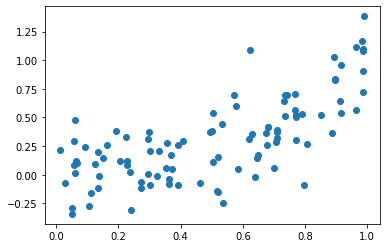

In [236]:
import matplotlib.pyplot as plt
plt.scatter(train_df[:, 0], train_df[:, 1])

To demonstrate an example, let's now fit an example model to this dataset and see how we can estimate their bias and variance.

## Polynomial Model (Linear Regression)

Note that what we're really doing is adding columns for a bias constant, $x^2$, and $x^3$, then applying linear regression, but I'm going to use the wonderful `np.polyfit` library instead. Note that conceptually, the model we're looking at here is a degree-3 polynomial model.

In [237]:
X = train_df[:, 0]
y = train_df[:, 1]
f_hat = np.poly1d(np.polyfit(X, y, 3))

In [238]:
print(np.poly1d(f_hat))

       3          2
1.578 x - 0.9744 x + 0.4041 x + 0.02554


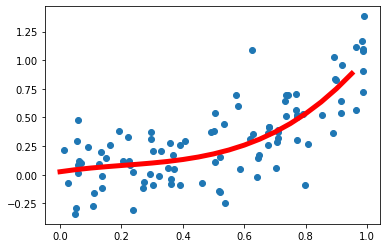

In [239]:
plt.scatter(train_df[:, 0], train_df[:, 1])
plt.plot(np.arange(0,1,0.05), f_hat(np.arange(0,1,0.05)), color='red', linewidth=5)

Not too bad, I must say.

But this is on the training set. The true quality of predictors is shown when applied on *unseen data*- test set data. Let's generate a random **noiseless** point from our model. This will be our test point $(x_0, y_0)$.

In [240]:
test_pt = generate_sample_data(f, num_rows=1, noise_sd=0)[0]
test_pt

array([0.85923005, 0.63434917])

When we try to use our degree-3 polynomial to predict this test pt, what do we get?

In [241]:
f_hat(test_pt[0])

0.6544474269993503

Not bad at all. But this could just be because we had a good training set. As stated in our bias estimation procedure, let's train multiple models, calculate the average prediction on $x_0$, then subtract from $y_0$. This will give us a good idea of the bias of the degree-3 polynomial.

To prevent exorbitant computation time, we'll only run 100 simulations, and use size-100 training sets per simulation.

In [242]:
def generate_predictions(f, test_x, n_sims=100):
    """Return size N-SIMS list of predictions of f_hat(test_x),
    each trained on N_SIMS different training sets."""
    estimates = []
    for _ in range(n_sims):
        data = generate_sample_data(f)
        X, y = data[:, 0], data[:, 1]
        f_hat = np.poly1d(np.polyfit(X, y, 3))
        pred = f_hat(test_x)
        estimates.append(pred)
    return estimates

In [243]:
def calculate_bias(f_hat, test_pt):
    """Estimate bias for model f_hat on test point TEST_PT."""
    preds = generate_predictions(f_hat, test_pt[0])
    avg_prediction = sum(preds) / len(preds)
    bias = avg_prediction - test_pt[1]
    return bias

In [244]:
print("For a degree 3 polynomial model, our bias estimate is: {}".format(calculate_bias(f_hat, test_pt)))

For a degree 3 polynomial model, our bias estimate is: 0.016457330735634268


Let's quickly estimate variance as well.

In [245]:
def calculate_variance(f_hat, test_pt):
    """Estimate variance for model f_hat on test point TEST_PT."""
    preds = generate_predictions(f_hat, test_pt[0])
    avg_prediction = sum(preds) / len(preds)
    squared_sampling_devs = np.square(np.array(preds) - avg_prediction)
    variance = sum(squared_sampling_devs) / len(squared_sampling_devs)
    return variance

In [246]:
print("For a degree 3 polynomial model, our variance estimate is: {}".format(calculate_variance(f_hat, test_pt)))

For a degree 3 polynomial model, our variance estimate is: 0.0016879565315766263


# Conclusion

When focused on a single test point, we can, in fact, estimate the bias and variance of a predictive model. You can use such numerical estimates to compare between different predictors for your ML problem.